In [19]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)


In [67]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [41]:
tickerSymbol = 'AZN'
data = yf.Ticker(tickerSymbol)

In [42]:
prices = data.history(start='2019-09-01', end='2020-05-31').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

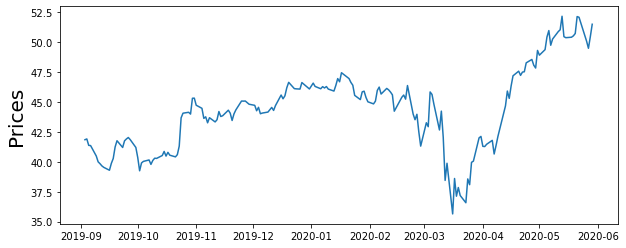

In [43]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

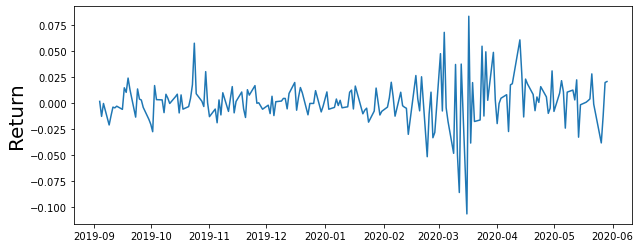

In [44]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

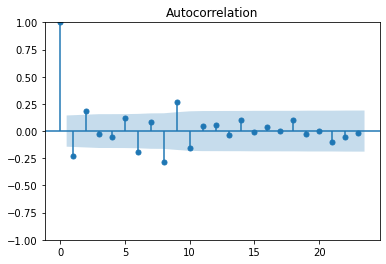

In [45]:
plot_acf(returns)
plt.show()

/Users/macbook/opt/anaconda3/envs/Deep/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


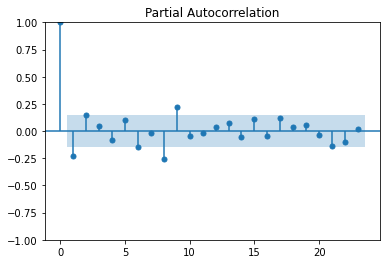

In [46]:
plot_pacf(returns)
plt.show()

### Baseline Model; Random Buying

100%|██████████| 172/172 [00:00<00:00, 7376.94it/s]


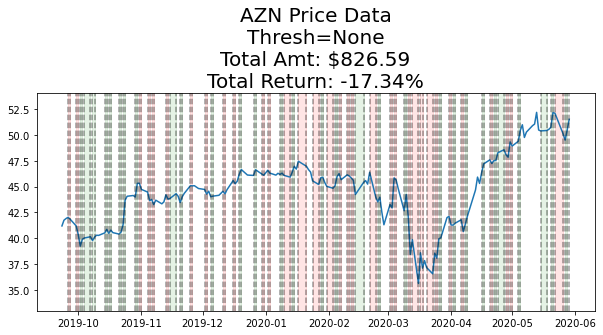

826.5851031532225

In [47]:
run_simulation(returns, prices, 1000, 0.5, None, verbose=False)

In [48]:
final_amts = [run_simulation(returns, prices, 1000, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 172/172 [00:00<00:00, 8350.35it/s]


100%|██████████| 172/172 [00:00<00:00, 7631.17it/s]


100%|██████████| 172/172 [00:00<00:00, 8489.59it/s]


100%|██████████| 172/172 [00:00<00:00, 7849.55it/s]


100%|██████████| 172/172 [00:00<00:00, 9325.62it/s]


100%|██████████| 172/172 [00:00<00:00, 8899.06it/s]


100%|██████████| 172/172 [00:00<00:00, 8721.65it/s]


/Users/macbook/opt/anaconda3/envs/Deep/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $1079.57\nSD: $177.3')

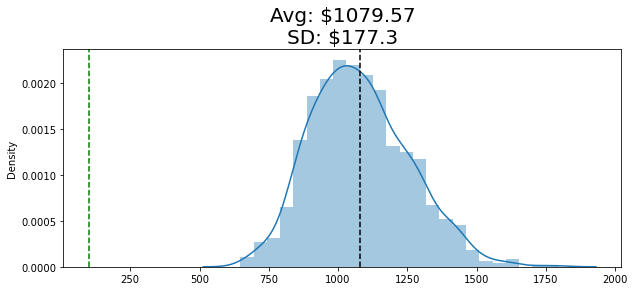

In [49]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

### Buy if last return was positive

100%|██████████| 172/172 [00:00<00:00, 6602.91it/s]


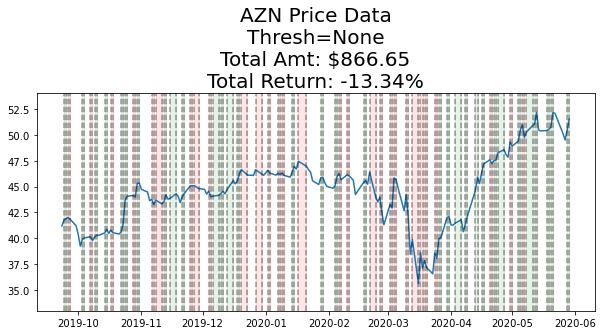

866.6492229201643

In [50]:
run_simulation(returns, prices, 1000, 'last', None, verbose=False)

### AR Model with p=1

100%|██████████| 172/172 [00:00<00:00, 6251.10it/s]


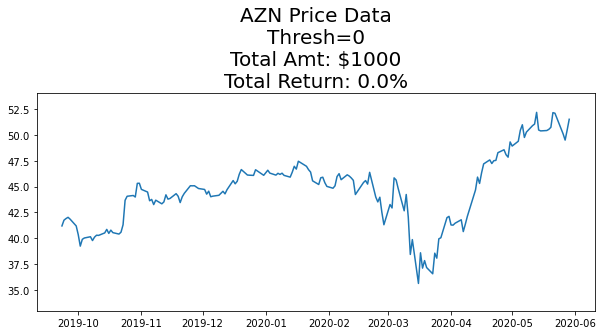

100%|██████████| 172/172 [00:00<00:00, 8472.94it/s]


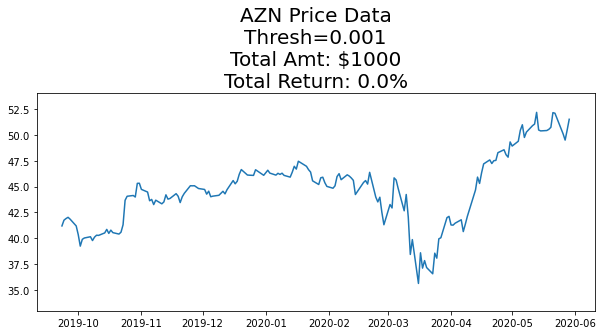

100%|██████████| 172/172 [00:00<00:00, 9534.40it/s]


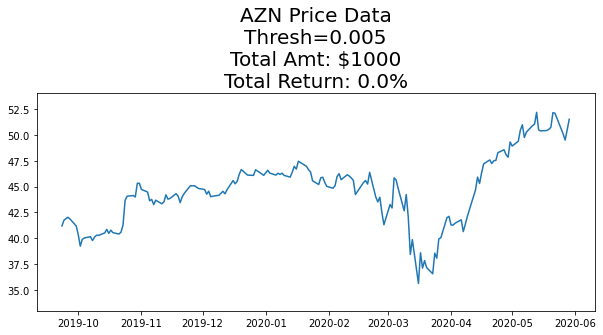

In [65]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 1000, (1,0,0), thresh, verbose=False)

### AR Model with p=5 

100%|██████████| 172/172 [00:00<00:00, 6190.80it/s]


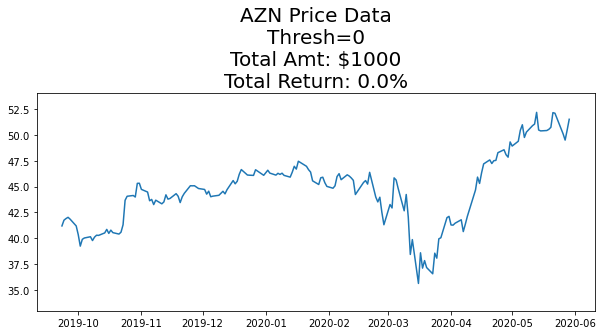

100%|██████████| 172/172 [00:00<00:00, 8670.60it/s]


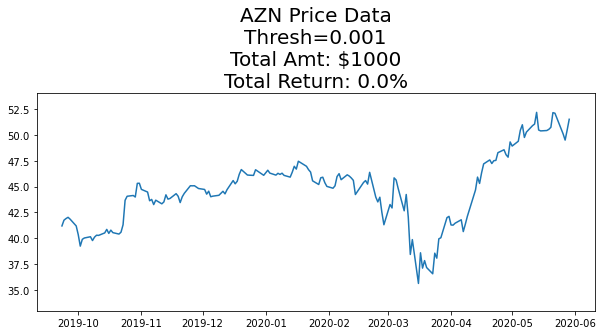

100%|██████████| 172/172 [00:00<00:00, 9926.12it/s]


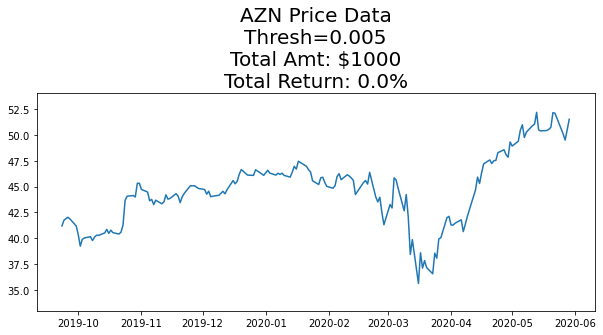

In [64]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 1000, (5,0,0), thresh, verbose=False)

### ARMA Model with p=2, q=6

100%|██████████| 172/172 [00:00<00:00, 7025.29it/s]


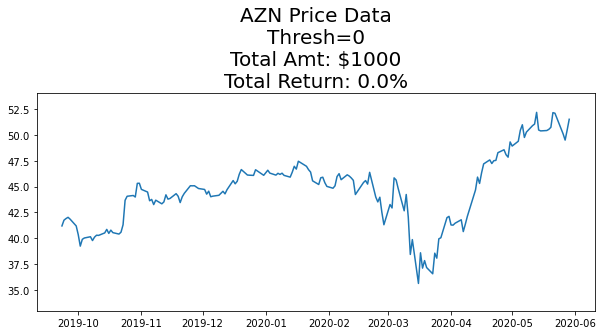

100%|██████████| 172/172 [00:00<00:00, 9505.50it/s]


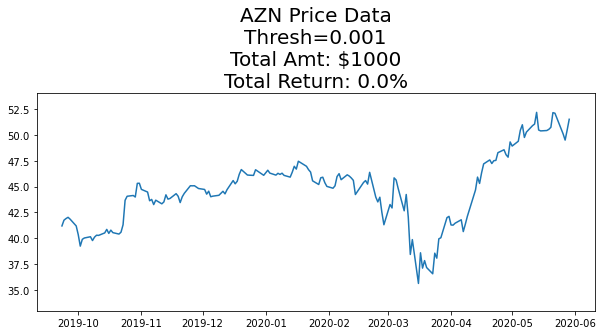

100%|██████████| 172/172 [00:00<00:00, 9872.46it/s]


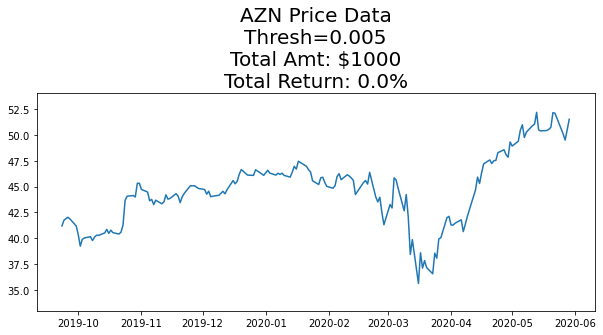

In [53]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 1000, (2,0,6), thresh, verbose=False)

### ARIMA Model with p=3, d=1, q=1

100%|██████████| 172/172 [00:00<00:00, 6954.52it/s]


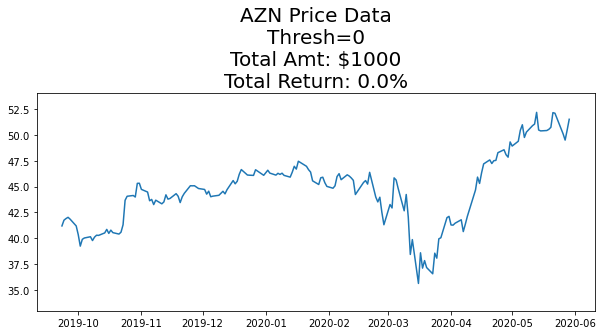

100%|██████████| 172/172 [00:00<00:00, 7709.62it/s]


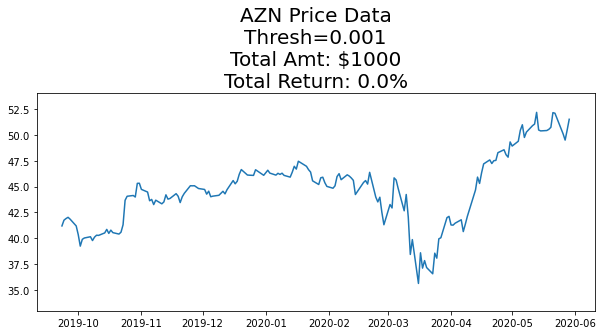

100%|██████████| 172/172 [00:00<00:00, 8148.14it/s]


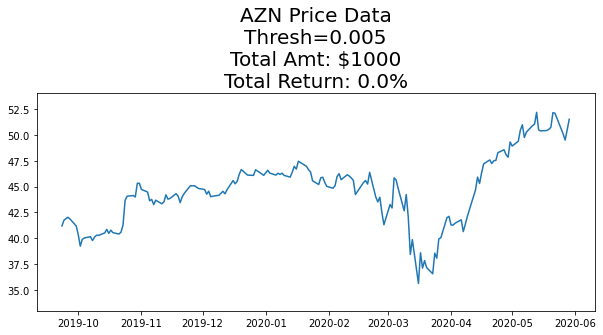

In [54]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 1000, (3,1,1), thresh, verbose=False)

### ARIMA Model with p=3, d=1, q=6

100%|██████████| 172/172 [00:00<00:00, 6622.24it/s]


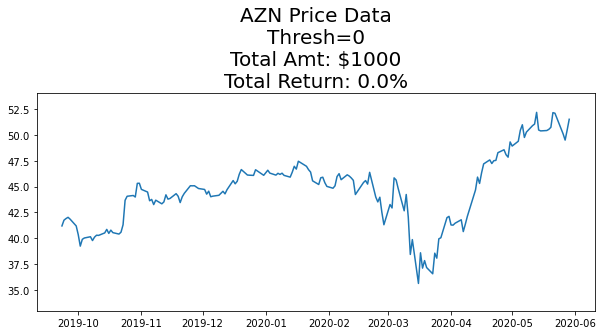

100%|██████████| 172/172 [00:00<00:00, 9486.51it/s]


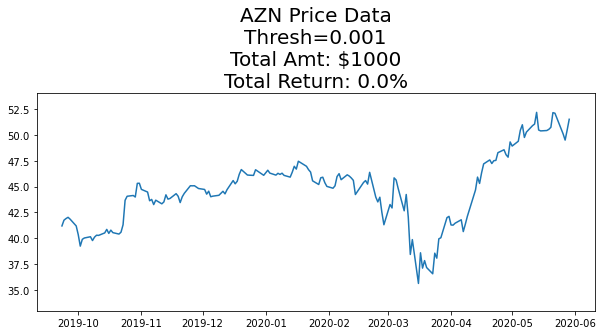

100%|██████████| 172/172 [00:00<00:00, 10093.32it/s]


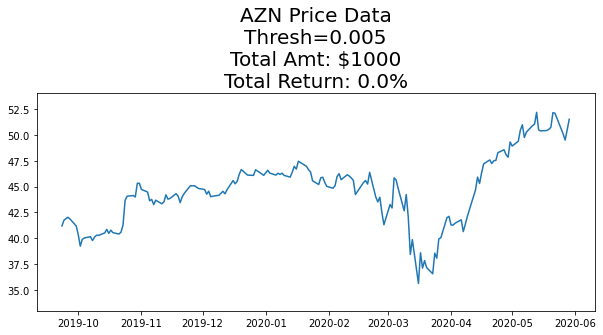

In [55]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 1000, (3,1,6), thresh, verbose=False)

100%|██████████| 172/172 [00:00<00:00, 7043.95it/s]


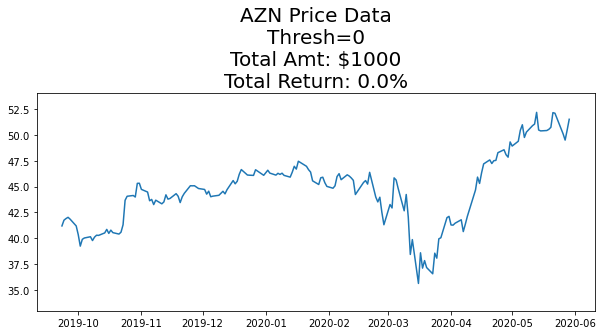

100%|██████████| 172/172 [00:00<00:00, 9818.31it/s]


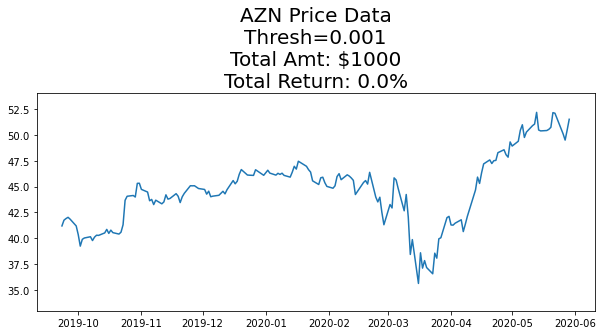

100%|██████████| 172/172 [00:00<00:00, 8931.34it/s]


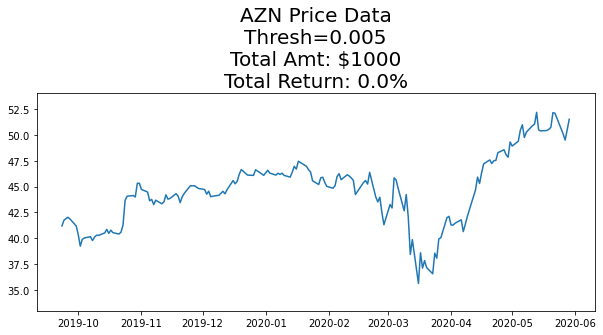

In [56]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 1000, (2,1,4), thresh, verbose=False)